In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Symbol,I,cos,plotting,zeros,Matrix,integrate,lambdify,factorial,exp,evalf,sin,sqrt
import sys
from scipy.integrate import quad
from tqdm import tqdm
sys.setrecursionlimit(20000)


## 调用函数
以下两个函数用于计算矩阵A，尝试使用符号计算直接进行积分的求解，结果证实算法速度过慢。因此采用符号计算求得泰勒级数，而后转而使用数值计算求解，在积分区间附近可以达到比较好的效果。


In [2]:
def double_taylor_series(matrix_A,pos,taylor_series):
    n_taylor_xy = taylor_series[pos[0]]
    n_taylor_x = n_taylor_xy*(x-expand)**(pos[1])
    n_taylor_x_numpy = lambdify(x,n_taylor_x,'numpy')
    #n_result = n_taylor_x.integrate((x,begin,end))
    n_result,_ = quad(n_taylor_x_numpy,begin,end)
    matrix_A[pos[1],pos[0]] = n_result
    return matrix_A

In [3]:
def construct_A(n,taylor_series):
    matrix_A = zeros(n)
    pos = []
    for p in range(0, n):
        for q in range(0, n):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = double_taylor_series(matrix_A,item,taylor_series)
    Lambda_diag = Lambda*np.matrix(np.diag(np.ones(n)))
    return Lambda_diag - matrix_A

In [4]:
def loop(n):
    taylor_series = []
    for i in tqdm(range(0, n)):
        taylor_series.append((K.diff(y,i)).subs(y,expand)/factorial(i))
    A_n = construct_A(n,taylor_series)
    y_ = zeros(n,1)
    for i in tqdm(range(n)):
        g_mod = g * (x-expand)**i
        g_mod_numpy = lambdify(x,g_mod,'numpy')
        result,_ = quad(g_mod_numpy,begin,end)
        y_[i, 0] = result
    A_n_acce = np.matrix(A_n).astype(np.float64)
    A_n_acce_inv = A_n_acce**(-1)
    A_n_inv = Matrix(A_n_acce_inv)
    c = A_n_inv*y_
    result = 0
    for i in range(n):
        result = result + taylor_series[i]*c[i,0]
    f_result = (1/Lambda*(result+g))
    disp_val = []
    for i in tqdm(range(len(x_list))):
        disp_val.append(f_result.evalf(subs={'x':x_list[i]}))
    loss = sqrt(np.sum((np.array(disp_val)-np.array(true_val))**2)/n)
    return f_result,loss

## 主函数
本程序通过插值法构造退化核，插值点考虑legendre、hebyshev、等距插值，进而求解第二类Fredholm方程。
$$\lambda f(x) - \int_a^{b} k(x,y)f(y) dy = g(x)$$

In [5]:
x = Symbol('x')   # 定义符号变量
y = Symbol('y')

In [6]:
## 以下为可供修改参数
begin = 0   # 对应方程中的a
end = 1   # b
Lambda = 1   # λ
expand=0   # 泰勒级数展开点
K = exp(x*y)   # K(x,y)
f_origin = 1+0*x+2*x   # 设定f的解，从而在后面求解得出相应g
## 以下参数用作作图
start = 2   # 起始展开阶数
total = 7   # 一共要做的图数
span = 2   # 跨度，相邻两张图展开阶数之差
tol = 5  # 用于伸展作图的区间

In [7]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
print(f"calculate g")
g

calculate g


2*x - Piecewise((-(x - 2)/x**2 + (3*x - 2)*exp(x)/x**2, (x > -oo) & (x < oo) & Ne(x, 0)), (2, True)) + 1

100%|██████████| 100/100 [00:00<00:00, 225.82it/s]


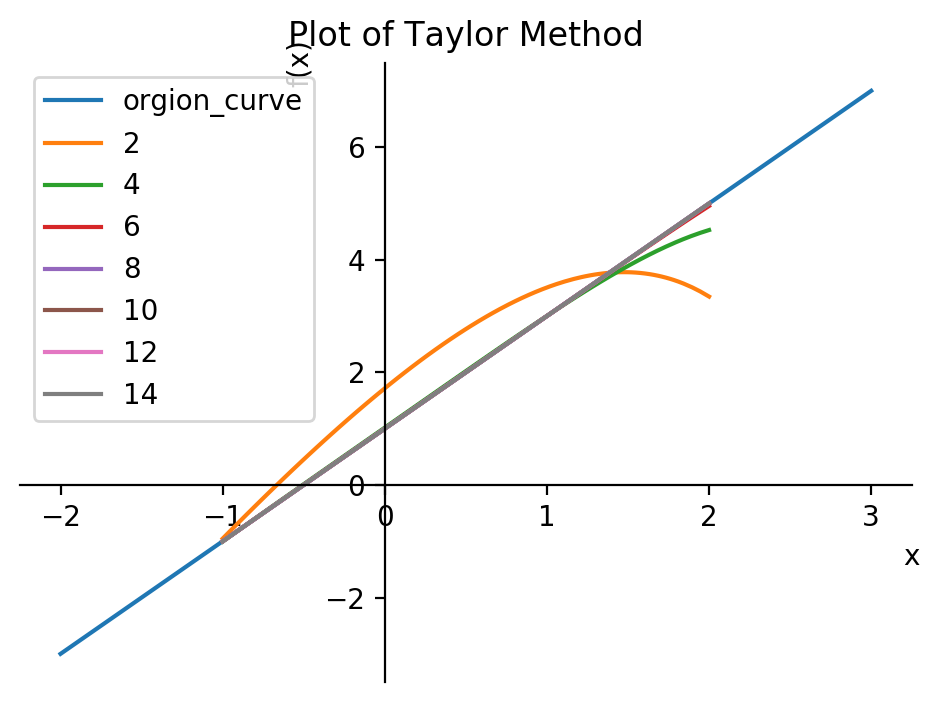

In [8]:
p = plotting.plot(f_origin,(x,begin-2,end+2),show=False,label='orgion_curve',legend=True)
err_list = []
x_begin = begin - tol
x_end = end + tol
x_list = np.arange(x_begin, x_end, (x_end - x_begin) / 100)
true_val = []
for i in tqdm(range(len(x_list))):
    true_val.append(f_origin.evalf(subs={'x': x_list[i]}))
for i in range(start,start+span*total,span):
    f_result,err = loop(i)
    err_list.append(np.log10(float(err)))
    p.append(plotting.plot(f_result,(x,begin-1,end+1) ,show=False,label=str(i))[0])
p.title = 'Plot of Taylor Method'
p.legend = True
p.show()

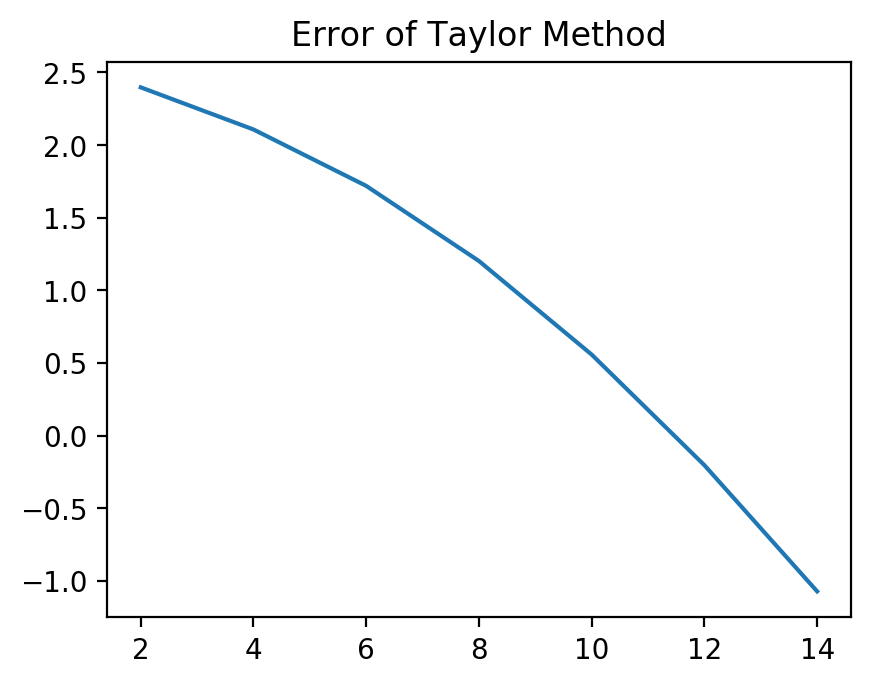

In [9]:
plt.plot(np.arange(start,start+span*total,span),err_list)
plt.title('Error of Taylor Method')
plt.show()